# Projecting ERA5 WRF data

This notebook is for projecting the WRF-downscaled ERA5 data.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import geopandas as gpd
from wrf import PolarStereographic
from pyproj import CRS, Transformer, Proj

Here is an example WRF file, from the 12km runs:

In [2]:
ds_12 = xr.open_dataset(
    "/beegfs/CMIP6/wrf_era5/12km/2000/era5_wrf_dscale_12km_2000-06-17.nc"
)
ds_12

<xarray.Dataset> Size: 683MB
Dimensions:       (Time: 24, south_north: 204, west_east: 264, interp_level: 9,
                   soil_layers_stag: 4)
Coordinates:
  * Time          (Time) datetime64[ns] 192B 2000-06-17 ... 2000-06-17T23:00:00
    XLONG         (south_north, west_east) float32 215kB ...
    XLAT          (south_north, west_east) float32 215kB ...
    XTIME         (Time) float32 96B ...
  * interp_level  (interp_level) float64 72B 200.0 300.0 500.0 ... 950.0 1e+03
Dimensions without coordinates: south_north, west_east, soil_layers_stag
Data variables: (12/43)
    slp           (Time, south_north, west_east) float32 5MB ...
    ctt           (Time, south_north, west_east) float32 5MB ...
    dbz           (Time, interp_level, south_north, west_east) float32 47MB ...
    rh2           (Time, south_north, west_east) float32 5MB ...
    T2            (Time, south_north, west_east) float32 5MB ...
    Q2            (Time, south_north, west_east) float32 5MB ...
    ...            ...
    u             (Time, interp_level, south_north, west_east) float32 47MB ...
    v             (Time, interp_level, south_north, west_east) float32 47MB ...
    w             (Time, interp_level, south_north, west_east) float32 47MB ...
    rainnc        (Time, south_north, west_east) float32 5MB ...
    rainc         (Time, south_north, west_east) float32 5MB ...
    acsnow        (Time, south_north, west_east) float32 5MB ...
Attributes:
    date:     2024-02-18T21:48:02.013730
    data:     Downscaled ERA5 using WRF
    info:     Alaska Climate Adaptation Science Center, University of Alaska ...
    contact:  cwaigl@alaska.edu
    version:  WRF V4.5.1 - project v. 1.1

This file includes projection information:

In [3]:
print(ds_12["T2"].attrs["projection"])

PolarStereographic(stand_lon=-152.0, moad_cen_lat=63.99999237060547, truelat1=64.0, truelat2=None, pole_lat=90.0, pole_lon=0.0)


We will need the center longitude attribute value from the geogrid file, as the standard longitude will not work:

In [4]:
geo_ds1 = xr.open_dataset("/beegfs/CMIP6/wrf_era5/geo_em.d01.nc")
geo_ds1.attrs["CEN_LON"]

-153.5

Then we will compute the grid's coordinate values by transforming the grid center latitude and longitude and doing some arithmetic:

In [5]:
# we only need these two attributes to reconstruct the projection
wrf_proj = PolarStereographic(
    **{"TRUELAT1": geo_ds1.attrs["TRUELAT1"], "STAND_LON": geo_ds1.attrs["STAND_LON"]}
).proj4()
# WGS84 projection
wgs_proj = Proj(proj="latlong", datum="WGS84")
wgs_to_wrf_transformer = Transformer.from_proj(wgs_proj, wrf_proj)

# this is where we plug in the center longitude of the domain to get the center x, y in projected space
e, n = wgs_to_wrf_transformer.transform(
    geo_ds1.attrs["CEN_LON"], geo_ds1.attrs["TRUELAT1"]
)
# now compute the rest of the grid based on x/y dimension lengths and grid spacing
dx = dy = 12000
nx = ds_12.XLONG.shape[1]
ny = ds_12.XLONG.shape[0]
x0 = -(nx - 1) / 2.0 * dx + e
y0 = -(ny - 1) / 2.0 * dy + n
# 2d grid coordinate values
x = np.arange(nx) * dx + x0
y = np.arange(ny) * dy + y0

print("Some X coordinates:", x[:5], "\n\nSome Y coordinates:", y[:5])

Some X coordinates: [-1651097.14406915 -1639097.14406915 -1627097.14406915 -1615097.14406915
 -1603097.14406915] 

Some Y coordinates: [-4009467.3110137 -3997467.3110137 -3985467.3110137 -3973467.3110137
 -3961467.3110137]


We can then recompute the latitudes and longitudes and plot the error between those and the originals as a sanity check:

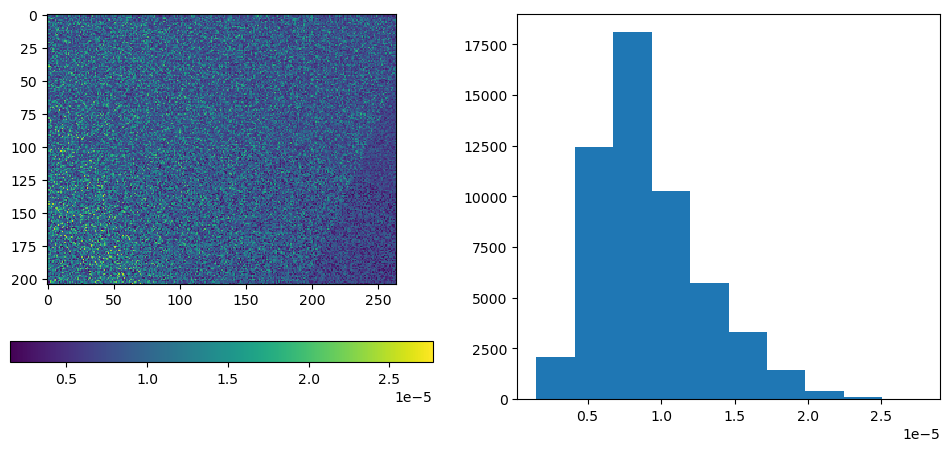

In [6]:
xx, yy = np.meshgrid(x, y)
wrf_to_wgs_transformer = Transformer.from_proj(wrf_proj, wgs_proj)
our_lons, our_lats = wrf_to_wgs_transformer.transform(xx, yy)
error_arr = np.sqrt(
    (our_lons - ds_12.XLONG.values) ** 2 + (our_lats - ds_12.XLAT.values) ** 2
)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
im = axs[0].imshow(error_arr, interpolation="none")
plt.colorbar(im, ax=axs[0], orientation="horizontal")
axs[1].hist(error_arr.flatten())
plt.show()

You can see these errors are all very small which suggests a good projection. 

We can compare with a shapefile:

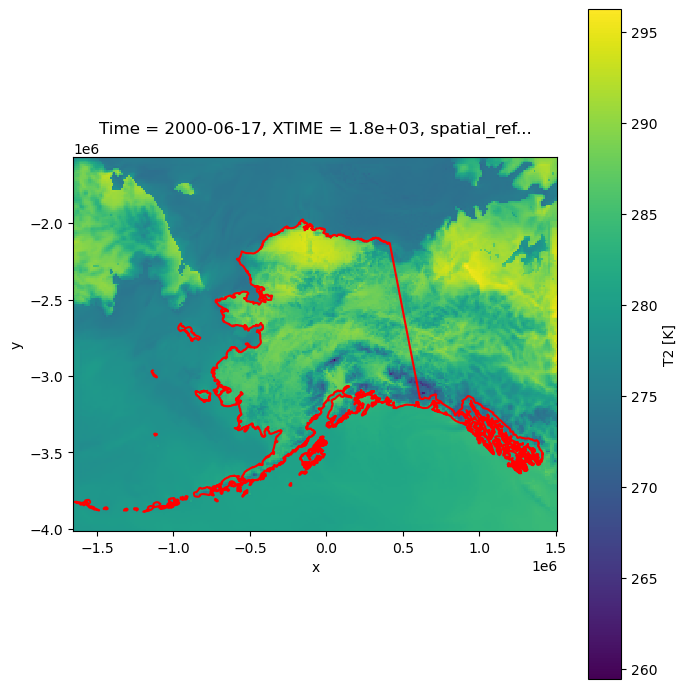

In [7]:
# read a shapefile and reproject to the WRF projection
gdf = gpd.read_file(
    "https://github.com/ua-snap/geospatial-vector-veracity/raw/main/vector_data/polygon/boundaries/alaska_coast_simplified/Alaska_Coast_Simplified_Polygon.shp"
)
wrf_crs = CRS.from_proj4(wrf_proj)
ak_shp_wrf = gdf.to_crs(wrf_crs)

# add the new coordinates to the dataset and set spatial info using rioxarray
ds_12_proj = (
    ds_12["T2"]
    .isel(Time=0)
    .rename({"south_north": "y", "west_east": "x"})
    .assign_coords({"y": ("y", y), "x": ("x", x)})
    .rio.set_spatial_dims("x", "y")
    .to_dataset()
    .rio.write_crs(wrf_crs)
)

# plot both
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ds_12_proj["T2"].plot(ax=ax)
ak_shp_wrf.boundary.plot(ax=ax, edgecolor="red")
plt.tight_layout()
plt.show()

This looks good. Now just saving it as a GeoTIFF for double-checking in GIS, etc.

In [8]:
ds_12_proj.rio.to_raster("sample_12km.tif")